In [1]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame,date_range
from matplotlib import cm
import seaborn as sns
import scipy as sp
import math
import warnings
import glob,os
from scipy.stats import kstest

warnings.filterwarnings('ignore')

In [42]:
# SNPs
folder = 'samtovcf/new//'
SNP=pd.read_csv('%s/model.sum..txt'%(folder), sep='\t')
SNP['Genome']=[x.split('.')[0] for x in SNP['sample']]

if 'covid' in folder:
    SNP['total_refSNP'] = [float(x.split('.fasta.')[1].split('.')[0]) for x in SNP['sample']]
    SNP['total SNPs'] = [int(x) for x in SNP['total_refSNP']]
    SNP['Tool']=[x.split('.fasta.')[2].split('.flt')[0].split('.vcf')[0] for x in SNP['sample']]
    SNP['tooldetauls'] = [x.split('.fasta.')[2] for x in SNP['sample']]
else:
    SNP['total_refSNP'] = [float(x.split('.corrected.')[1].split('.')[0]) for x in SNP['sample']]
    SNP['Tool']=[x.split('SNP.fasta.')[1].split('.flt')[0].split('.vcf')[0] for x in SNP['sample']]
    SNP['tooldetauls'] = [x.split('SNP.fasta.')[1] for x in SNP['sample']]
    ref_snp = pd.read_csv('%s/../ref_snp.txt'%(folder),sep='\t',header=None)
    ref_snp.columns=['total SNPs','sample']
    ref_snp['total SNPs'] = [int(x) for x in ref_snp['total SNPs']]
    SNP['sample'] = [x.split('.SNP.fasta')[0] + '.SNP.fasta.snp.txt' for x in SNP['sample']]
    SNP = SNP.merge(ref_snp,left_on = 'sample',right_on = 'sample',how = 'left')
    
print(SNP['Tool'].unique())
SNP['VCF caller'] = ''
SNP['VCF caller']=[x.replace('bowtie','').replace('minimap','').replace('bwa','').replace('.mappersamtovcf','Variant identifier').replace('.bcfdefault','bcftools default').replace('.indel','bcftools indel') for x in SNP['Tool']]
SNP['VCF caller']=[x.replace('Variant identifier','VARIANTS').replace('VARIANTS','QuickVariants') for x in SNP['VCF caller']]
SNP.loc[SNP['Tool'].isin(['bowtie','bwa','minimap']),'VCF caller'] = 'bcftools Mul-ALT'
SNP['Tool'] = [x.split('.')[0].replace('bowtie','bowtie2').replace('minimap','minimap2') for x in SNP['Tool']]
# filter by duplicate kmers > 10000
SNP = SNP[~SNP['Genome'].isin(['am_BaFr_gS1T203',
                               'H20_BA_g0002',
                               'P63_BA_01','an_EsCo_g0001','cx_BaTh_g0001',
                               'bq_BaTh_g0001'])]
genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}

SNP['Genome'] = [genome_set.get(x,x) for x in SNP['Genome']]
SNP['FPrate']=SNP['FP']/SNP['total SNPs']
SNP['FNrate']=SNP['FN']/SNP['total SNPs']
allgenome = SNP['Genome'].unique()
print(allgenome)
SNP['Tool VCF caller'] = SNP['Tool'] + '-' + SNP['VCF caller']
SNP = SNP.sort_values(['Genome','Tool','VCF caller','total_refSNP'])
SNP=SNP[SNP['total_refSNP']!=0]
print(SNP['Tool'].unique(),SNP['VCF caller'].unique())
SNP.head()


['bwa.indel' 'minimap.indel' 'minimap.mappersamtovcf' 'minimap.bcfdefault'
 'bwa' 'bowtie.indel' 'bowtie.mappersamtovcf' 'bwa.mappersamtovcf'
 'bowtie' 'bowtie.bcfdefault' 'minimap' 'bwa.bcfdefault']
['AkMu' 'BiAd' 'BaFr' 'BaOv' 'BaVu' 'PaDi' 'BaFa' 'EsCo' 'BaXy']
['bowtie2' 'bwa' 'minimap2'] ['QuickVariants' 'bcftools Mul-ALT' 'bcftools default' 'bcftools indel']


,sample,FP,FN,total_refSNP,Genome,Tool,tooldetauls,total SNPs,VCF caller,FPrate,FNrate,Tool VCF caller
64,am_AkMu_g0002.fasta.corrected.1e-06.SNP.fasta....,7,0,0.000001,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,24,QuickVariants,0.291667,0.000000,bowtie2-QuickVariants
99,am_AkMu_g0002.fasta.corrected.2e-06.SNP.fasta....,0,0,0.000002,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,24,QuickVariants,0.000000,0.000000,bowtie2-QuickVariants
142,am_AkMu_g0002.fasta.corrected.3e-06.SNP.fasta....,0,0,0.000003,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,27,QuickVariants,0.000000,0.000000,bowtie2-QuickVariants
173,am_AkMu_g0002.fasta.corrected.4e-06.SNP.fasta....,0,0,0.000004,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,29,QuickVariants,0.000000,0.000000,bowtie2-QuickVariants
229,am_AkMu_g0002.fasta.corrected.5e-06.SNP.fasta....,0,1,0.000005,AkMu,bowtie2,bowtie.mappersamtovcf.vcf.final.vcf,30,QuickVariants,0.000000,0.033333,bowtie2-QuickVariants


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


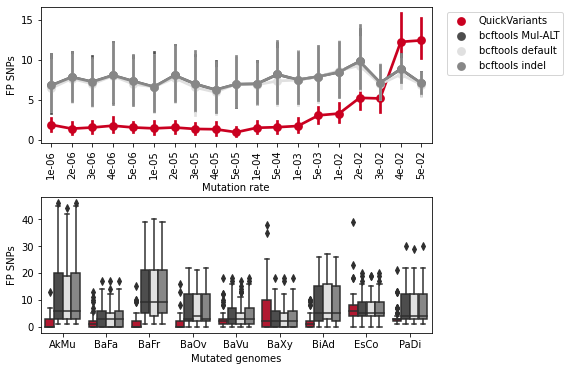

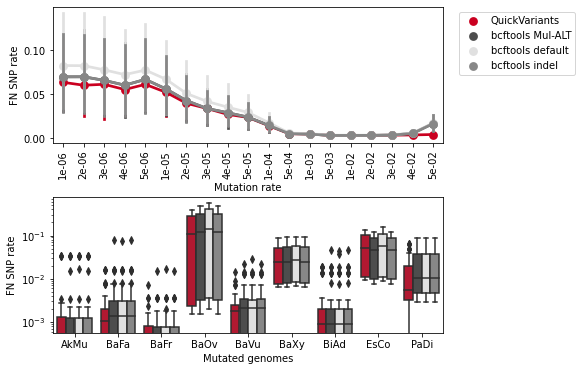

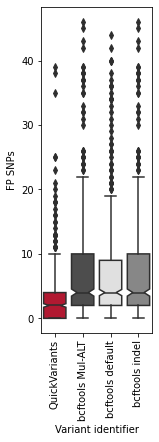

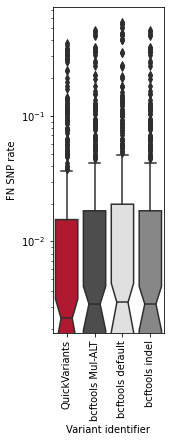

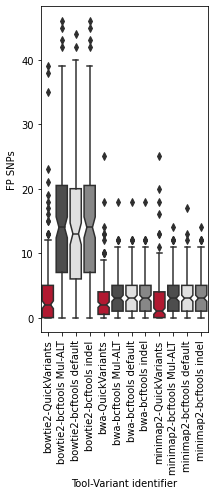

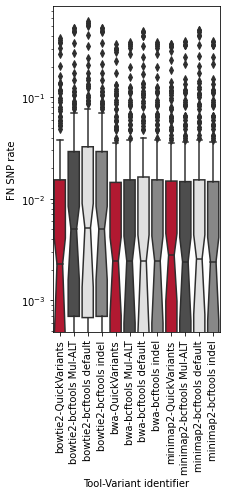

In [43]:
# plot FP
pallete_set = {
        'QuickVariants':'#ca0020','bcftools Mul-ALT':'#4d4d4d','bcftools default':'#e0e0e0','bcftools indel':'#878787'}


for genome in allgenome:
    SNPsub = SNP[SNP['Genome']==genome]
# plot FN sum for mutations and genomes
if 'covid' not in folder:
    SNP['total_refSNP']=['%.0e'%(x) for x in SNP['total_refSNP']]
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FP SNPs')
    plt.sca(axs[0])
    plt.legend(bbox_to_anchor=(1.35, 1.0))
    sns.boxplot(x='Genome', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FP SNPs')
    axs[1].get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 3a.pdf'%(folder),bbox_inches='tight')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FN SNP rate')
    #axs[0].set(yscale="log")
    plt.sca(axs[0])
    plt.legend(bbox_to_anchor=(1.35, 1.0))
    sns.boxplot(x='Genome', y='FNrate', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FN SNP rate')
    axs[1].set(yscale="log")
    axs[1].get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 3b.eps'%(folder),bbox_inches='tight',format='eps')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
    axs.set_xlabel('Variant identifier') 
    axs.set_ylabel('FP SNPs')
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    #plt.sca(axs)
    #plt.legend(bbox_to_anchor=(1.4, 1.0))
    plt.savefig('%s/Figure 3c.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FNrate', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Variant identifier') 
    axs.set_ylabel('FN SNP rate')
    axs.set(yscale="log")
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    plt.savefig('%s/Figure 3d.eps'%(folder),bbox_inches='tight',format='eps')
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
    axs.set_xlabel('Tool-Variant identifier') 
    axs.set_ylabel('FP SNPs')
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    #plt.sca(axs)
    #plt.legend(bbox_to_anchor=(1.4, 1.0))
    plt.savefig('%s/Figure S3a.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FNrate', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-Variant identifier') 
    axs.set_ylabel('FN SNP rate')
    axs.set(yscale="log")
    plt.xticks(rotation=90)
    axs.get_legend().remove()
    plt.savefig('%s/Figure S3b.eps'%(folder),bbox_inches='tight',format='eps')
else:
    # plot FP
    SNP['FPrate'] = SNP['FP']/SNP['total_refSNP']
    SNP['FNrate'] = SNP['FN']/SNP['total_refSNP']
    SNP = SNP[SNP['total_refSNP']!=0]
    SNP['total_refSNP']=[int(x) for x in SNP['total_refSNP']]
    # plot FP sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(5,2),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.3)
    sns.boxplot(x='VCF caller', y='FP',notch = True,  data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('Variant identifier') 
    axs[0].set_ylabel('FP SNPs')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FP SNPs')
    plt.sca(axs[1])
    plt.legend(bbox_to_anchor=(1.1, 1.0))
    plt.xticks(rotation=90)
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 4c.pdf'%(folder),bbox_inches='tight')

    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(5,2),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.3)
    sns.boxplot(x='VCF caller', y='FN',notch = True,  data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('Variant identifier') 
    axs[0].set_ylabel('FN SNPs')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FN', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FN SNPs')
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.sca(axs[1])
    plt.legend(bbox_to_anchor=(1.1, 1.0))
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 4d.eps'%(folder),bbox_inches='tight',format='eps')


In [134]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['total_refSNP','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VARIANTS','FNrate'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95]),
          np.mean(SNPspeciessub['FNrate']),np.std(SNPspeciessub['FNrate']))
    

KstestResult(statistic=0.21052631578947367, pvalue=0.808061649945869)
VARIANTS [0.         0.00216294 0.01750656] 0.005135305202625477 0.00791363856190319
bcftools Mul-ALT [0.         0.00271125 0.01750656] 0.0057172392256264635 0.0077795521803778545
bcftools default [0.         0.00269663 0.01750656] 0.005760535903396427 0.007760462253023748
bcftools indel [0.         0.00271125 0.01750656] 0.0057172392256264635 0.0077795521803778545


In [414]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['total_refSNP','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VARIANTS','FNrate'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95]),
          np.mean(SNPspeciessub['FNrate']),np.std(SNPspeciessub['FNrate']))
    

KstestResult(statistic=0.21052631578947367, pvalue=0.808061649945869)
VARIANTS [0.         0.00216294 0.01750656] 0.005135305202625477 0.00791363856190319
bcftools Mul-ALT [0.         0.00271125 0.01750656] 0.0057172392256264635 0.0077795521803778545
bcftools default [0.         0.00269663 0.01750656] 0.005760535903396427 0.007760462253023748
bcftools indel [0.         0.00271125 0.01750656] 0.0057172392256264635 0.0077795521803778545


In [135]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['total_refSNP','VCF caller'])['FP'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VARIANTS','FP'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools Mul-ALT','FP'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FP'],[0.05,0.5,0.95]),np.mean(SNPspeciessub['FP']),np.std(SNPspeciessub['FP']))
    

KstestResult(statistic=0.6842105263157895, pvalue=0.00015621221647240893)
VARIANTS [0.  1.  9.1] 2.0 2.772040859423935
bcftools Mul-ALT [2. 4. 7.] 4.315789473684211 1.4528603938781328
bcftools default [2.  4.  6.1] 4.2631578947368425 1.331485330597212
bcftools indel [2. 4. 7.] 4.315789473684211 1.4528603938781328


In [416]:
# MO
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)

KstestResult(statistic=0.3586744639376218, pvalue=1.048653561197757e-29)
KstestResult(statistic=0.050682261208576995, pvalue=0.5256422817954437)
KstestResult(statistic=0.025341130604288498, pvalue=0.9966107799426185)
KstestResult(statistic=0.02729044834307992, pvalue=0.9911275456215753)


In [481]:
# MO
print(np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.5])/
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],[0.5]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.5])/
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.5]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.5])/
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.5]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.5])/
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.5]),
     )

print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)


[2.] [1.30080557] [1.] [0.97089756]
FP [ 0.   2.  12.4] [ 0.  4. 25.] [ 0.  4. 25.] [ 0.  4. 26.]
FNrate [ 0.          0.24355042 13.33297367] [ 0.          0.31681175 14.01175602] [ 0.          0.31681175 14.01175602] [ 0.          0.32630811 17.3269541 ]


In [418]:
SNP['total_refSNP'].unique()

array(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02', '4e-02', '5e-02'], dtype=object)

In [419]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04', '5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'])
)

FP [0. 1. 8.] [ 0.   4.  25.1]
FNrate [ 0.          0.23704406 13.95158515] [ 0.          0.3111824  15.88580825] [ 0.          0.32246919 20.31878848]
KstestResult(statistic=0.40522875816993464, pvalue=4.421577674195134e-34)
KstestResult(statistic=0.04139433551198257, pvalue=0.8270809328477107)


In [420]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['1e-06', '2e-06', '3e-06', '4e-06', '5e-06', '1e-05', '2e-05',
       '3e-05', '4e-05', '5e-05', '1e-04'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'])
)

FP [0. 1. 5.] [ 0.  4. 25.]
FNrate [ 0.          0.53763441 27.06501131] [ 0.          0.72992701 31.03794058] [ 0.          0.72992701 40.36369079]
KstestResult(statistic=0.4276094276094276, pvalue=9.609827383444913e-25)
KstestResult(statistic=0.026936026936026935, pvalue=0.9999244914859051)


In [421]:
# MO
SNPsub = SNP[SNP['total_refSNP'].isin(['5e-04', '1e-03', '5e-03',
       '1e-02', '2e-02', '3e-02'])]
print('FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]))
print('FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],
      SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'])
)

FP [ 0.  2. 11.] [ 1.    5.   32.65]
FNrate [0.05787617 0.20174656 1.08778925] [0.05400523 0.22513429 1.05151328] [0.05381304 0.24041202 1.2247231 ]
KstestResult(statistic=0.36419753086419754, pvalue=6.050621933939212e-10)
KstestResult(statistic=0.08024691358024691, pvalue=0.6756221846892806)


In [422]:
for Tool in SNP['Tool'].unique():
    SNPsub = SNP[SNP['Tool']==Tool]
    print(Tool,'FP',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]),
         np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
    print(Tool,'FNrate',np.quantile(SNPsub.loc[SNPsub['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
             np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
             np.quantile(SNPsub.loc[SNPsub['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)



bowtie2 FP [ 0.   2.  15.5] [ 3.  14.  37.5] [ 2. 13. 36.]
bowtie2 FNrate [ 0.          0.22550965 13.82477041] [ 0.          0.50038898 16.1855811 ] [ 0.          0.51625239 19.25362933]
bwa FP [ 0.  2. 10.] [0.  3.  9.5] [0. 3. 9.]
bwa FNrate [ 0.          0.2441682  12.64443277] [ 0.          0.24355042 12.4565649 ] [ 0.          0.24355042 15.39245974]
minimap2 FP [ 0.  1. 10.] [ 0.   3.  10.5] [ 0.  3. 10.]
minimap2 FNrate [ 0.          0.2768332  12.62254902] [ 0.          0.23931847 12.6483856 ] [ 0.          0.25630389 15.8430161 ]


In [423]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VARIANTS'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VARIANTS'),'FP'])
)

KstestResult(statistic=0.631578947368421, pvalue=1.1102230246251565e-15)
KstestResult(statistic=0.05263157894736842, pvalue=0.9725604546148136)
KstestResult(statistic=0.11988304093567251, pvalue=0.0734289522037952)
KstestResult(statistic=0.15789473684210525, pvalue=0.028006814020783834)


In [424]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VARIANTS'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'])
)

KstestResult(statistic=0.14619883040935672, pvalue=0.01469498215557441)
KstestResult(statistic=0.03508771929824561, pvalue=0.9999451670875277)
KstestResult(statistic=0.038011695906432746, pvalue=0.9960442783067602)
KstestResult(statistic=0.05847953216374269, pvalue=0.932944329455469)


In [425]:
# MO
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,
          np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95])*100,
          np.mean(SNPspeciessub['FNrate'])*100,
          np.std(SNPspeciessub['FNrate'])
         )
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FP'].median())
SNPspecies.reset_index(inplace=True)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,
         np.quantile(SNPspeciessub['FP'],[0.05,0.5,0.95]),
          np.mean(SNPspeciessub['FP']),
          np.std(SNPspeciessub['FP'])
         )

VARIANTS [0.         0.18224065 8.42354246] 2.1202024974300975 0.034146812520816174
bcftools Mul-ALT [0.         0.20920502 8.97657822] 2.2684471092857206 0.03700442949045097
bcftools default [ 0.          0.20751619 10.95264989] 2.700148493492839 0.04525282730764911
bcftools indel [0.         0.20920502 8.97657822] 2.2684471092857206 0.03700442949045097
VARIANTS [0.  1.  4.8] 1.6666666666666667 1.8257418583505536
bcftools Mul-ALT [2.4 4.  7.8] 4.444444444444445 2.006163342807532
bcftools default [2.4 4.  7.8] 4.555555555555555 1.9499920860871383
bcftools indel [2.4 4.  7.8] 4.444444444444445 2.006163342807532


In [120]:
# covid

print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print('FN',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FN'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FN'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FN'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FN'],[0.05,0.5,0.95]))
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)


FP [0. 0. 1.] [0. 0. 4.] [0. 0. 4.] [0. 0. 3.]
FN [0. 1. 3.] [0.  0.5 3. ] [0.  0.5 3. ] [0. 0. 3.]
KstestResult(statistic=0.19166666666666668, pvalue=0.024139111559378406)
KstestResult(statistic=0.025, pvalue=0.9999999999999869)


In [44]:
# indels
folder = 'samtovcf/new/'
SNP=pd.read_csv(glob.glob('%s/modelindelsum*.txt'%(folder))[0], sep='\t')

SNP['Genome']=[x.split('.')[0] for x in SNP['Sample']]
SNP = SNP[SNP['Genome'] != 'am_BaFr_gS1T203']
SNP = SNP[SNP['Genome'] != 'H20_BA_g0002']
if 'covid' in folder:
    SNP['total_refSNP'] = [float(x.split('.fasta.')[1].split('.')[0]) for x in SNP['Sample']]
    SNP['FNrate']=SNP['FN']/20
else:
    SNP['total_refSNP'] = [float(x.split('.corrected.')[1].split('.')[0]) for x in SNP['Sample']]
    SNP['FN'] = SNP['FN']
    SNP['FNrate']=SNP['FN']/200
    #SNP = SNP[SNP['total_refSNP']!=4e-02][SNP['total_refSNP']!=1e-02]
    print(SNP['total_refSNP'].unique())
    ref_snp = pd.read_csv('samtovcf/ref_snp.txt',sep='\t',header=None)
    ref_snp.columns=['total SNPs','sample']
    ref_snp['total SNPs'] = [int(x) for x in ref_snp['total SNPs']]
#SNP = SNP.sort_values('Tool')
genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}
SNP['Genome'] = [genome_set[x] for x in SNP['Genome']]
allgenome = SNP['Genome'].unique()
print(SNP['Tool'].unique())
SNP['VCF caller'] = ''
SNP['Tool'] = [x.replace('bowtie ','bowtie2 ').replace('minimap ','minimap2 ') for x in SNP['Tool']]
SNP['VCF caller']=[x.replace('bowtie2 VARIANTS','QuickVariants'
                            ).replace('minimap2 VARIANTS','QuickVariants'
                                     ).replace('bwa VARIANTS','QuickVariants'
                                              ).replace('bowtie2 indel','bcftools indel'
                            ).replace('minimap2 indel','bcftools indel'
                                     ).replace('bwa indel','bcftools indel'
                                              ).replace('bowtie2 bcfdefault','bcftools default'
                            ).replace('minimap2 bcfdefault','bcftools default'
                                     ).replace('bwa bcfdefault','bcftools default'
                                              ).replace('bowtie2','bcftools Mul-ALT'
                            ).replace('minimap2','bcftools Mul-ALT'
                                     ).replace('bwa','bcftools Mul-ALT'
                                              ) for x in SNP['Tool']]
SNP['Tool'] = [x.split(' ')[0] for x in SNP['Tool']]
SNP['Tool VCF caller'] = SNP['Tool'] + '-' + SNP['VCF caller']
SNP['Sample'] = [x.split('.SNP.fasta')[0] + '.SNP.fasta.snp.txt' for x in SNP['Sample']]
if 'covid' not in folder:
    SNP = SNP.merge(ref_snp,left_on = 'Sample',right_on = 'sample',how = 'left')
SNP = SNP.sort_values(['total_refSNP','Genome','Tool','VCF caller'])
print(SNP['total_refSNP'].unique())
print(SNP['Tool'].unique(),SNP['VCF caller'].unique())
print(allgenome)
SNP.head()


[0.e+00 5.e-06 1.e-03 1.e-05 5.e-04 5.e-02 2.e-06 3.e-05 3.e-02 4.e-05
 1.e-06 3.e-06 2.e-05 1.e-04 4.e-06 2.e-02 5.e-05 5.e-03 1.e-02 4.e-02]
['bowtie2' 'bwa' 'minimap2' 'bowtie2 VARIANTS' 'bwa VARIANTS'
 'minimap2 VARIANTS' 'bowtie2 bcfdefault' 'bwa bcfdefault'
 'minimap2 bcfdefault' 'bowtie2 indel' 'bwa indel' 'minimap2 indel']
[0.e+00 1.e-06 2.e-06 3.e-06 4.e-06 5.e-06 1.e-05 2.e-05 3.e-05 4.e-05
 5.e-05 1.e-04 5.e-04 1.e-03 5.e-03 1.e-02 2.e-02 3.e-02 4.e-02 5.e-02]
['bowtie2' 'bwa' 'minimap2'] ['QuickVariants' 'bcftools Mul-ALT' 'bcftools default' 'bcftools indel']
['BaFa' 'PaDi' 'BiAd' 'EsCo' 'BaOv' 'BaXy' 'AkMu' 'BaFr' 'BaVu']


,Sample,Tool,FN,TP,FP_samePOS,FP_diffPOS,Genome,total_refSNP,FNrate,VCF caller,Tool VCF caller,total SNPs,sample
75,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt,bowtie2,200,0,0,16,AkMu,0.0,1.0,QuickVariants,bowtie2-QuickVariants,0,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt
72,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt,bowtie2,200,0,0,1,AkMu,0.0,1.0,bcftools Mul-ALT,bowtie2-bcftools Mul-ALT,0,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt
78,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt,bowtie2,200,0,0,2,AkMu,0.0,1.0,bcftools default,bowtie2-bcftools default,0,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt
81,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt,bowtie2,200,0,0,33,AkMu,0.0,1.0,bcftools indel,bowtie2-bcftools indel,0,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt
76,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt,bwa,200,0,0,0,AkMu,0.0,1.0,QuickVariants,bwa-QuickVariants,0,am_AkMu_g0002.fasta.corrected.0.SNP.fasta.snp.txt


['1e-06' '2e-06' '3e-06' '4e-06' '5e-06' '1e-05' '2e-05' '3e-05' '4e-05'
 '5e-05' '1e-04' '5e-04' '1e-03' '5e-03' '1e-02' '2e-02' '3e-02' '4e-02'
 '5e-02']


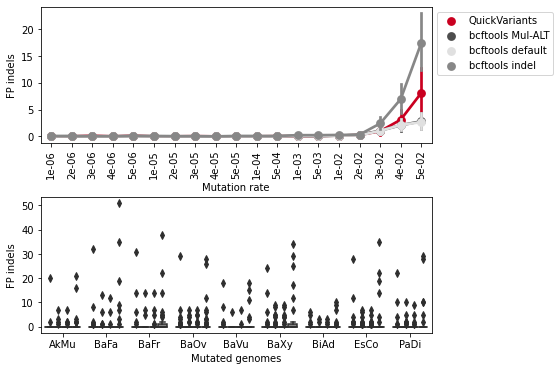

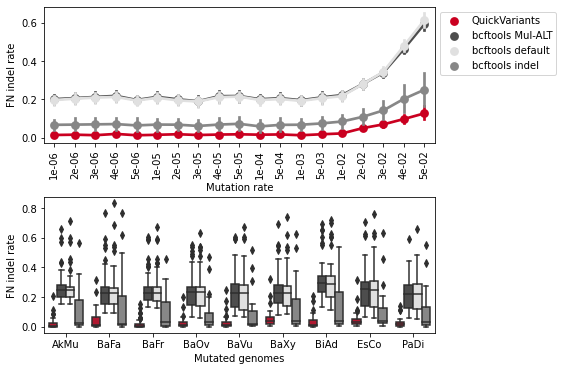

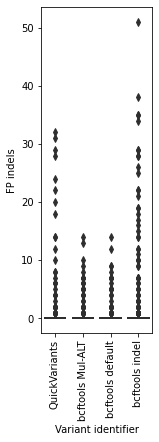

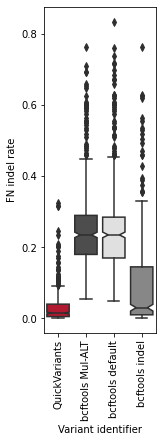

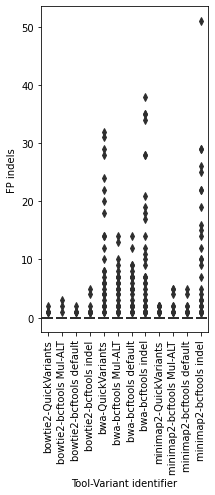

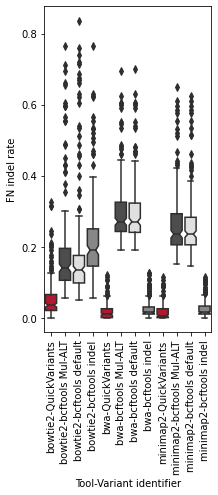

In [45]:
# plot FP sum for mutations and genomes
pallete_set = {
        'QuickVariants':'#ca0020','bcftools Mul-ALT':'#4d4d4d','bcftools default':'#e0e0e0','bcftools indel':'#878787'}

if 'covid' not in folder:
    SNPsuball = pd.DataFrame()
    for genome in allgenome:
        SNPsub = SNP[SNP['Genome']==genome]
        # correct for FP diff location at 0 SNPs
        if True:
            SNPsub_0 = SNPsub[SNPsub['total_refSNP']==0].loc[:,['Tool VCF caller','FP_samePOS','FP_diffPOS']]
            SNPsub = SNPsub[SNPsub['total_refSNP']!=0]
            SNPsub = SNPsub.merge(SNPsub_0,left_on = 'Tool VCF caller',right_on = 'Tool VCF caller',how = 'left')
            SNPsub['FP']=SNPsub['FP_diffPOS_x']-SNPsub['FP_diffPOS_y']
            SNPsub.loc[SNPsub['FP']<0,'FP'] =0
            SNPsuball = SNPsuball.append(SNPsub)
    SNP = SNPsuball
    SNP = SNP.sort_values(['total_refSNP','Genome','Tool','VCF caller'])
    SNP['total_refSNP']=['%.0e'%(x) for x in SNP['total_refSNP']]
    print(SNP['total_refSNP'].unique())
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FP', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FP indels')
    axs[0].get_legend().remove()
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    sns.boxplot(x='Genome', y='FP', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FP indels')
    axs[1].get_legend().remove()
    plt.savefig('%s/Figure 2a.pdf'%(folder))
    # FN sum
    fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(7, 6))
    plt.subplots_adjust(hspace=0.4)
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNP,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
    axs[0].set_xlabel('Mutation rate') 
    axs[0].set_ylabel('FN indel rate')
    #axs[0].set(yscale="log")
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    sns.boxplot(x='Genome', y='FNrate', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('Mutated genomes') 
    axs[1].set_ylabel('FN indel rate')
    #axs[1].set(yscale="log")
    axs[1].get_legend().remove()
    plt.savefig('%s/Figure 2b.pdf'%(folder))
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Variant identifier') 
    axs.set_ylabel('FP indels')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 2c.pdf'%(folder),bbox_inches='tight')
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 6))
    sns.boxplot(x='VCF caller', y='FNrate',notch = True,  data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Variant identifier') 
    axs.set_ylabel('FN indel rate')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure 2d.pdf'%(folder),bbox_inches='tight')
    SNP = SNP[SNP['total_refSNP']!=0]
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FP', notch = True, data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-Variant identifier') 
    axs.set_ylabel('FP indels')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure S2c.pdf'%(folder),bbox_inches='tight')
    # plot FN sum for mutations and genomes
    fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
    sns.boxplot(x='Tool VCF caller', y='FNrate',notch = True,  data=SNP,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs.set_xlabel('Tool-Variant identifier') 
    axs.set_ylabel('FN indel rate')
    axs.get_legend().remove()
    plt.xticks(rotation=90)
    plt.savefig('%s/Figure S2d.pdf'%(folder),bbox_inches='tight')
    SNP = SNP[SNP['total_refSNP']!=0]
else:
    SNP['sampleshort']=[x.split('.')[0] + '.' + x.split('.SNP')[1].split('.')[0] for x in SNP['Sample']]
    allgenome = SNP['sampleshort'].unique()
    SNP = SNP.sort_values(['total_refSNP','Genome','Tool','VCF caller'])
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(5,2),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.4)
    sns.boxplot(x='VCF caller', y='FP_diffPOS', notch = True, data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('Variant identifier') 
    axs[0].set_ylabel('FP indels')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FP_diffPOS', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FP indels')
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.sca(axs[1])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.1, 1.0))
    plt.savefig('%s/Figure 4a.pdf'%(folder),bbox_inches='tight')
    fig, axs = plt.subplots(nrows=1,ncols = 2,figsize=(5,2),gridspec_kw={'width_ratios': [1, 2]})
    plt.subplots_adjust(wspace=0.4)
    sns.boxplot(x='VCF caller', y='FNrate',notch = True,  data=SNP,ax=axs[0],hue = 'VCF caller',dodge=False,palette=pallete_set)
    axs[0].set_xlabel('Variant identifier') 
    axs[0].set_ylabel('FN indel rate')
    axs[0].get_legend().remove()
    sns.pointplot(x='total_refSNP', y='FNrate', data=SNP,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
    axs[1].set_xlabel('No. mutations') 
    axs[1].set_ylabel('FN indel rate')
    plt.sca(axs[0])
    plt.xticks(rotation=90)
    plt.sca(axs[1])
    plt.xticks(rotation=90)
    plt.legend(bbox_to_anchor=(1.1, 1.0))
    plt.savefig('%s/Figure 4b.pdf'%(folder),bbox_inches='tight')
    

In [131]:
# covid
print('FP',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP_diffPOS'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP_diffPOS'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FP_diffPOS'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP_diffPOS'],[0.05,0.5,0.95]))
print('FN',np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[0.05,0.5,0.95])*100,
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP_diffPOS'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP_diffPOS'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP_diffPOS'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FP_diffPOS'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP_diffPOS'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FP_diffPOS'])
)

print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'])
)

print(kstest(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'])
)

FP [0. 0. 0.] [0. 0. 0.] [0.   0.   1.05] [0. 0. 0.]
FN [ 0.  0. 10.] [15. 35. 50.] [50. 70. 85.] [15. 35. 50.]
KstestResult(statistic=0.008333333333333333, pvalue=1.0)
KstestResult(statistic=0.36666666666666664, pvalue=1.4439886846546988e-07)
KstestResult(statistic=0.35833333333333334, pvalue=3.0755083673165016e-07)
KstestResult(statistic=0.9666666666666667, pvalue=2.9660071147981457e-63)
KstestResult(statistic=1.0, pvalue=2.2001332500149066e-71)
KstestResult(statistic=0.85, pvalue=1.247561257832528e-44)


In [138]:
# MO
print(sum(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools indel','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FN'])
     )
print(sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FP']),
     sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FN']))
print(sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FP'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP']),
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FN'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FN'])
     )
print(np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FP'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],[0.05,0.5,0.95]))
print('FP',
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print(np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FNrate'],[0.05,0.5,0.95])*100,
     np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.05,0.5,0.95])*100)
print('FNrate',
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100,
                 np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95]),

           np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.05,0.5,0.95]),
)
print(sum(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='bcftools default','FN']))


2.1937321937321936 2.94359135067377
0.9373219373219374 0.4982764023816985
2.090909090909091 3.858213616489694
[0. 0. 0.] [0. 0. 1.] [0. 0. 0.]
FP [0. 0. 2.] [ 0.  0. 10.] [0. 0. 2.] [0. 0. 2.]
[0. 1. 6.] [ 0.   2.5 24.5] [ 9. 22. 32.]
FNrate [ 0.   1.5 11. ] [ 0.5  3.  28.7] [ 9.  23.5 53.9] [ 8.8 23.5 54. ] [0.03  0.075 0.235] [0.285 0.44  0.66 ]
1.0042745006606046


In [472]:
# MO
print(sum(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FP']),
      sum(SNP.loc[SNP['VCF caller']=='bcftools indel','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FN'])
     )
print(sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FP']),
     sum(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FN'])/
      sum(SNP.loc[SNP['VCF caller']=='VARIANTS','FN']))
print(sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FP'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP']),
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FN'])/
      sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FN'])
     )
print(np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FP'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],[0.05,0.5,0.95]))
print('FP',
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],[0.05,0.5,0.95]),
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],[0.05,0.5,0.95]))
print(np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FNrate'],[0.05,0.5,0.95])*100,
     np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.05,0.5,0.95])*100)
print('FNrate',
      np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95])*100,
      np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95])*100,
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.05,0.5,0.95])*100,
                 np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95]),

           np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.05,0.5,0.95]),
)
print(sum(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FN'])/
      sum(SNP.loc[SNP['VCF caller']=='bcftools default','FN']))


2.1937321937321936 2.94359135067377
0.9373219373219374 0.4982764023816985
2.090909090909091 3.858213616489694
[0. 0. 0.] [0. 0. 1.] [0. 0. 0.]
FP [0. 0. 2.] [ 0.  0. 10.] [0. 0. 2.] [0. 0. 2.]
[0. 1. 6.] [ 0.   2.5 24.5] [ 9. 22. 32.]
FNrate [ 0.   1.5 11. ] [ 0.5  3.  28.7] [ 9.  23.5 53.9] [ 8.8 23.5 54. ] [0.03  0.075 0.235] [0.285 0.44  0.66 ]
1.0042745006606046


In [466]:
print(np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[
    0.5])/np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.5
                                                                   ]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[
    0.5])/np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.5
                                                                   ]))


[15.66666667] [2.]


In [467]:
np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[
    0.5])/np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.5
                                                                   ])

array([15.66666667])

In [401]:
np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[
    0.5])/np.quantile(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],[0.5
                                                                   ])

array([1.])

In [484]:
print(np.quantile(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],[0.05,0.5,0.95]),
         np.quantile(SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'],[0.05,0.5,0.95]))

[0.    0.015 0.11 ] [0.09  0.235 0.539] [0.005 0.03  0.287]


In [403]:
print(np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95]),
     np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'],[0.05,0.5,0.95]))


[0.   0.01 0.06] [0. 0. 0.]


In [404]:
np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.5])/np.quantile(SNP.loc[
    (~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.5])

array([22.])

In [473]:
np.quantile(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FNrate'],[0.5])/np.quantile(SNP.loc[
    (~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.5])

array([2.5])

In [405]:
1-sum(SNP.loc[(~SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'])/sum(
SNP.loc[:,'FP'])

0.9850034083162917

In [487]:
print(np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FNrate'],[0.05,0.5,0.95])*100,
 np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FNrate'],[0.05,0.5,0.95])*100,
           np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],[0.05,0.5,0.95])*100)

[ 3.   7.5 23.5] [ 4.5  9.5 56.5] [28.5 44.  66. ]


In [488]:
print(np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='VARIANTS'),'FP'],[0.05,0.5,0.95]),
 np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools indel'),'FP'],[0.05,0.5,0.95]),
           np.quantile(SNP.loc[(SNP['total_refSNP'].isin(['3e-02','4e-02','5e-02']))&(SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],[0.05,0.5,0.95]))

[ 0.  0. 24.] [ 0.  4. 34.] [0. 0. 8.]


In [476]:
SNPspecies = pd.DataFrame(SNP.groupby(['Genome','VCF caller'])['FNrate'].median())
SNPspecies.reset_index(inplace=True)
print(kstest(SNPspecies.loc[SNPspecies['VCF caller']=='VARIANTS','FNrate'],
      SNPspecies.loc[SNPspecies['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
for VCFcaller in SNPspecies['VCF caller'].unique():
    SNPspeciessub = SNPspecies[SNPspecies['VCF caller']==VCFcaller]
    print(VCFcaller,np.quantile(SNPspeciessub['FNrate'],[0.05,0.5,0.95])*100,
          np.mean(SNPspeciessub['FNrate'])*100,
          np.std(SNPspeciessub['FNrate']))
    

KstestResult(statistic=1.0, pvalue=4.11353352529823e-05)
VARIANTS [0.5 1.  3.3] 1.4444444444444446 0.010122703976826998
bcftools Mul-ALT [22.2 23.  27.9] 23.944444444444446 0.022291558497487637
bcftools default [22.2 23.  27.1] 23.833333333333336 0.018856180831641256
bcftools indel [2. 3. 4.] 3.0000000000000004 0.007071067811865475


<AxesSubplot:xlabel='VCF caller', ylabel='FNrate'>

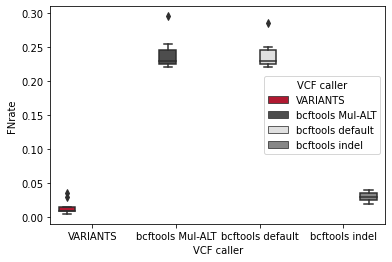

In [408]:
sns.boxplot(x='VCF caller', y='FNrate',  data=SNPspecies,hue = 'VCF caller',palette=pallete_set)


In [490]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools indel'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools indel'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools indel'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools indel'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FP'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FP'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FP'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VARIANTS'),'FP'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VARIANTS'),'FP'])
)


KstestResult(statistic=0.13742690058479531, pvalue=0.026035802471532143)
KstestResult(statistic=0.03508771929824561, pvalue=0.9999451670875277)
KstestResult(statistic=0.10526315789473684, pvalue=0.15623395625078762)
KstestResult(statistic=0.14035087719298245, pvalue=0.06880160004126318)
KstestResult(statistic=0.09064327485380116, pvalue=0.3005252129339563)
KstestResult(statistic=0.13450292397660818, pvalue=0.0906464511545769)


In [491]:
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools indel'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools indel'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools indel'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools indel'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='bcftools Mul-ALT'),'FNrate'])
)
from scipy.stats import kstest
print(kstest(SNP.loc[(SNP['Tool']=='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'],
      SNP.loc[(SNP['Tool']!='bowtie2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'])
)
print(kstest(SNP.loc[(SNP['Tool']=='bwa') & (SNP['VCF caller']=='VARIANTS'),'FNrate'],
      SNP.loc[(SNP['Tool']=='minimap2') & (SNP['VCF caller']=='VARIANTS'),'FNrate'])
)

KstestResult(statistic=0.9093567251461988, pvalue=1.1102230246251565e-15)
KstestResult(statistic=0.023391812865497075, pvalue=0.9999999999798249)
KstestResult(statistic=0.6637426900584795, pvalue=1.1102230246251565e-15)
KstestResult(statistic=0.2982456140350877, pvalue=4.109391976248092e-07)
KstestResult(statistic=0.45321637426900585, pvalue=1.1102230246251565e-15)
KstestResult(statistic=0.029239766081871343, pvalue=0.9999996734018008)


In [468]:
# MO
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools indel','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools Mul-ALT','FNrate'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FP'],
      SNP.loc[SNP['VCF caller']=='bcftools default','FP'])
)
print(kstest(SNP.loc[SNP['VCF caller']=='VARIANTS','FNrate'],
      SNP.loc[SNP['VCF caller']=='bcftools default','FNrate'])
)

KstestResult(statistic=0.017543859649122806, pvalue=0.9999986537558455)
KstestResult(statistic=0.884990253411306, pvalue=6.687223880337755e-211)
KstestResult(statistic=0.07602339181286549, pvalue=0.10311979566794738)
KstestResult(statistic=0.2884990253411306, pvalue=3.2377532429931436e-19)
KstestResult(statistic=0.003898635477582846, pvalue=1.0)
KstestResult(statistic=0.025341130604288498, pvalue=0.9966107799426185)
KstestResult(statistic=0.01949317738791423, pvalue=0.9999757442557087)
KstestResult(statistic=0.8791423001949318, pvalue=2.656464411446613e-207)


In [2]:
# Time
folder = 'samtovcf/new/15thread/'
pallete_set = {
        'QuickVariants':'#ca0020','QuickVariants total':'#f4a582','bcftools total':'#e0e0e0','bcftools':'#878787'}

Time=pd.read_csv('%s/alltimesum.txt'%(folder), sep='\t')

Time['Genome']=[x.split('.')[0] for x in Time['fasta']]

genome_set = {'am_BA_g0003':'BiAd',
                 'am_BaFr_g0050':'BaFr',
                 'am_BaSa_g0015':'BaSa',
             'am_AkMu_g0002':'AkMu','am_BaOv_g0001':'BaOv',
              'am_BaVu_g0002':'BaVu','am_EsCo_g0005':'EsCo',
             'am_PaDi_g0001':'PaDi','SRR2842672':'human',
             'aa_BaFa_g0001':'BaFa-aa','bf_BaFa_g0001':'BaFa',
              'bj_EsCo_g0001':'EsCo','cx_BaXy_g0001':'BaXy','SRR10971381':'SARS-COV-2'}
Time['Genome'] = [genome_set[x] for x in Time['Genome']]
allgenome = Time['Genome'].unique()
Time['Tool'] = Time['tool']
print(Time['Tool'].unique())
Time['VCF caller']=[x.replace('VARIANTS','QuickVariants').replace('(',
                                                                  '').replace(')',
                                                                  '') for x in Time['VCF caller']]
Time = Time.sort_values(['Genome','Tool','VCF caller','SNP'])
print(Time['Tool'].unique(),Time['VCF caller'].unique())
print(allgenome)
Time['Tool VCF caller'] = Time['Tool'] + '-' + Time['VCF caller']
Time['SNP']=['%.0e'%(x) for x in Time['SNP']]
Time=Time[Time['VCF caller'].isin(['QuickVariants','bcftools'])]
Time.head()


['bowtie2' 'minimap2' 'bwa']
['bowtie2' 'bwa' 'minimap2'] ['QuickVariants' 'QuickVariants total' 'bcftools' 'bcftools total']
['BaXy' 'EsCo' 'AkMu' 'BaFr' 'PaDi' 'BaVu' 'BaFa' 'BiAd' 'BaOv']


,fasta,SNP,tool,VCF caller,Total time,Genome,Tool,Tool VCF caller
781,am_AkMu_g0002,1e-06,bowtie2,QuickVariants,6.47,AkMu,bowtie2,bowtie2-QuickVariants
337,am_AkMu_g0002,2e-06,bowtie2,QuickVariants,6.49,AkMu,bowtie2,bowtie2-QuickVariants
613,am_AkMu_g0002,3e-06,bowtie2,QuickVariants,6.68,AkMu,bowtie2,bowtie2-QuickVariants
1681,am_AkMu_g0002,4e-06,bowtie2,QuickVariants,6.23,AkMu,bowtie2,bowtie2-QuickVariants
25,am_AkMu_g0002,5e-06,bowtie2,QuickVariants,6.46,AkMu,bowtie2,bowtie2-QuickVariants


In [3]:
# samfile size
filesize = pd.read_csv('%s/../samsize.txt'%(folder),sep='\t',header=None)
filesize.columns=['sam size','file']
filesize['file']=[x.replace('.fasta','').replace('.SNP','').replace('.corrected','').replace('.sam','').replace('minimap','minimap2').replace('bowtie','bowtie2') for x in filesize['file']]
Time['file']=Time['fasta'] + '.' + [str(x) for x in Time['SNP']] + '.' + Time['Tool']
Time2=Time[Time['SNP']!='0e+00']
Time2 = Time2.merge(filesize,left_on = 'file',right_on = 'file',how='left')
Time2['sam size'] = [int(x)/1e6 for x in Time2['sam size']]
Time2.head()


,fasta,SNP,tool,VCF caller,Total time,Genome,Tool,Tool VCF caller,file,sam size
0,am_AkMu_g0002,1e-06,bowtie2,QuickVariants,6.47,AkMu,bowtie2,bowtie2-QuickVariants,am_AkMu_g0002.1e-06.bowtie2,2827.039285
1,am_AkMu_g0002,2e-06,bowtie2,QuickVariants,6.49,AkMu,bowtie2,bowtie2-QuickVariants,am_AkMu_g0002.2e-06.bowtie2,2827.070182
2,am_AkMu_g0002,3e-06,bowtie2,QuickVariants,6.68,AkMu,bowtie2,bowtie2-QuickVariants,am_AkMu_g0002.3e-06.bowtie2,2827.009534
3,am_AkMu_g0002,4e-06,bowtie2,QuickVariants,6.23,AkMu,bowtie2,bowtie2-QuickVariants,am_AkMu_g0002.4e-06.bowtie2,2827.028066
4,am_AkMu_g0002,5e-06,bowtie2,QuickVariants,6.46,AkMu,bowtie2,bowtie2-QuickVariants,am_AkMu_g0002.5e-06.bowtie2,2827.060077


In [52]:
np.quantile(Time2.loc[(Time2['sam size']>=800)&(
Time2['sam size']<=1500)&(Time2['VCF caller']=='bcftools'),'Total time'],[0.5])

array([21.5])

In [53]:
np.quantile(Time2.loc[(Time2['sam size']>=2000)&(
Time2['sam size']<=3000)&(Time2['VCF caller']=='bcftools'),'Total time'],[0.5])

array([55.57])

In [54]:
np.quantile(Time2.loc[(Time2['sam size']>=4000)&(Time2['VCF caller']=='bcftools'),'Total time'],[0.5])

array([120.35])

In [4]:
np.quantile(Time2.loc[(Time2['sam size']>=800)&(
Time2['sam size']<=1500)&(Time2['VCF caller']=='QuickVariants'),'Total time'],[0.5])

array([3.205])

In [5]:
np.quantile(Time2.loc[(Time2['sam size']>=2000)&(
Time2['sam size']<=3000)&(Time2['VCF caller']=='QuickVariants'),'Total time'],[0.5])

array([5.88])

In [6]:
np.quantile(Time2.loc[(Time2['sam size']>=4000)&(Time2['VCF caller']=='QuickVariants'),'Total time'],[0.5])

array([10.43])

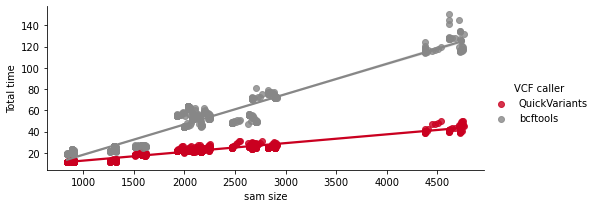

In [4]:
sns.lmplot(x='sam size', y='Total time', data=Time2,
            hue = 'VCF caller',palette=pallete_set,height=3, aspect=7/3)
plt.savefig('%s/Figure Sam.pdf'%(folder))


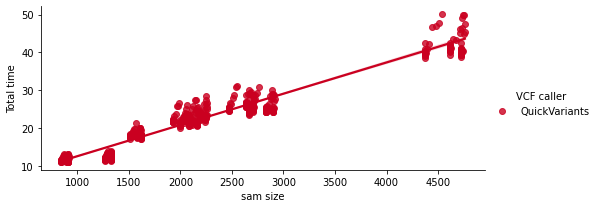

In [5]:
sns.lmplot(x='sam size', y='Total time', data=Time2[Time2['VCF caller']=='QuickVariants'],
            hue = 'VCF caller',palette=pallete_set,height=3, aspect=7/3)


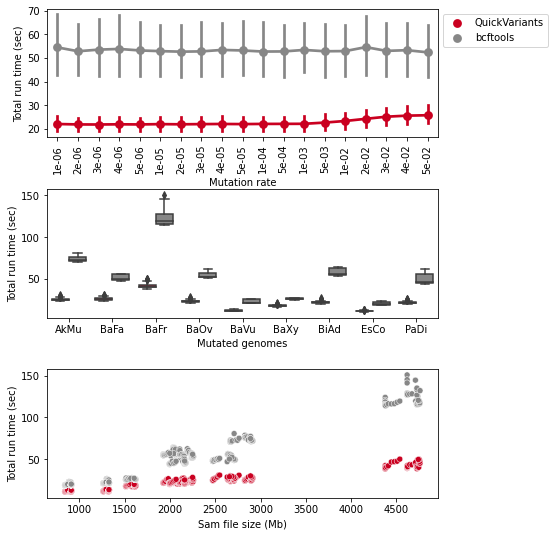

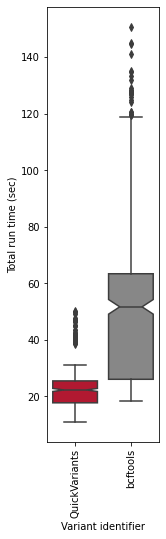

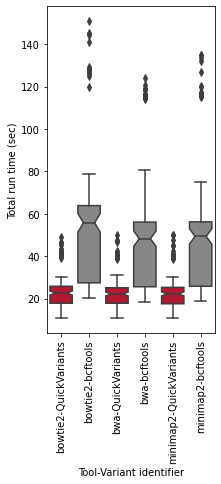

In [6]:
fig, axs = plt.subplots(nrows=3,ncols = 1,figsize=(7, 9))
plt.subplots_adjust(hspace=0.4)
sns.pointplot(x='SNP', y='Total time', data=Time,ax=axs[0],hue = 'VCF caller',palette=pallete_set)
axs[0].set_xlabel('Mutation rate') 
axs[0].set_ylabel('Total run time (sec)')
axs[0].get_legend().remove()
plt.sca(axs[0])
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 1.0))

sns.boxplot(x='Genome', y='Total time', data=Time,ax=axs[1],hue = 'VCF caller',palette=pallete_set)
axs[1].set_xlabel('Mutated genomes') 
axs[1].set_ylabel('Total run time (sec)')
axs[1].get_legend().remove()

sns.scatterplot(x='sam size', y='Total time', data=Time2,
            ax=axs[2],hue = 'VCF caller',palette=pallete_set)
axs[2].set_xlabel('Sam file size (Mb)') 
axs[2].set_ylabel('Total run time (sec)')
axs[2].get_legend().remove()
plt.savefig('%s/Figure 1a.pdf'%(folder))

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(2, 8))
sns.boxplot(x='VCF caller', y='Total time',notch = True,  data=Time,ax=axs,hue = 'VCF caller',dodge=False,palette=pallete_set)
axs.set_xlabel('Variant identifier') 
axs.set_ylabel('Total run time (sec)')
axs.get_legend().remove()
plt.xticks(rotation=90)
plt.savefig('%s/Figure 1b.pdf'%(folder),bbox_inches='tight')

fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 6))
sns.boxplot(x='Tool VCF caller', y='Total time', notch = True, data=Time,ax=axs,hue = 'VCF caller',dodge=False,palette = pallete_set)
axs.set_xlabel('Tool-Variant identifier') 
axs.set_ylabel('Total run time (sec)')
plt.xticks(rotation=90)
axs.get_legend().remove()
plt.savefig('%s/Figure S4.pdf'%(folder),bbox_inches='tight')


<AxesSubplot:xlabel='Total time', ylabel='Count'>

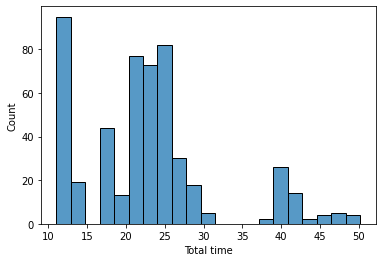

In [8]:
sns.histplot(data = Time[Time['VCF caller']=='QuickVariants'],x = 'Total time')

<AxesSubplot:xlabel='Total time', ylabel='Count'>

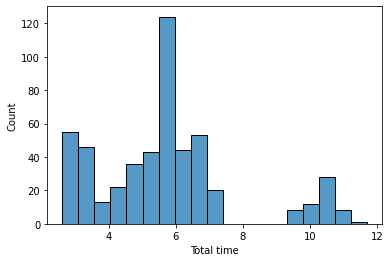

In [12]:
sns.histplot(data = Time[Time['VCF caller']=='QuickVariants'],x = 'Total time')

In [27]:
#15 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.05,0.5,0.95]),
     
     )
print(np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.5])/
     np.quantile(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],[0.5]))

Time [ 2.866  5.66  10.46 ] [ 19.378  52.03  122.37 ]
[9.19257951]


In [28]:
# 15 thread
print(kstest(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],
      Time.loc[Time['VCF caller']=='bcftools','Total time'])
)


KstestResult(statistic=1.0, pvalue=1.116847523521345e-307)


In [9]:
#1 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.05,0.5,0.95]),
     
     )
print(np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.5])/
     np.quantile(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],[0.5]))

Time [11.466 22.29  41.006] [ 19.444  51.68  120.066]
[2.31852849]


In [10]:
# 1 thread
print(kstest(Time.loc[Time['VCF caller']=='QuickVariants','Total time'],
      Time.loc[Time['VCF caller']=='bcftools','Total time'])
)

KstestResult(statistic=0.6413255360623782, pvalue=1.4359521046707863e-99)


In [170]:
#30 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='VARIANTS','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.05,0.5,0.95]),
     
     )
print(np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.5])/
     np.quantile(Time.loc[Time['VCF caller']=='VARIANTS','Total time'],[0.5]))

Time [ 5.28 10.42 17.9 ] [ 19.31  51.44 126.82]
[4.93666027]


In [458]:
#30 thread
print('Time',np.quantile(Time.loc[Time['VCF caller']=='VARIANTS','Total time'],[0.05,0.5,0.95]),
 np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.05,0.5,0.95]),
     
     )

print(np.quantile(Time.loc[Time['VCF caller']=='bcftools','Total time'],[0.5])/
     np.quantile(Time.loc[Time['VCF caller']=='VARIANTS','Total time'],[0.5]))

Time [ 3.74   7.86  13.783] [ 5.388 11.585 22.07 ] [ 20.0395  53.215  123.153 ] [ 21.839   57.47   131.7845]
7.110038884252765 6.577539905186333
[6.77035623] [4.96072508] [0.92596137] [0.67846353]


In [160]:
# 30 thread
print(kstest(Time.loc[Time['VCF caller']=='VARIANTS','Total time'],
      Time.loc[Time['VCF caller']=='bcftools','Total time'])
)


KstestResult(statistic=0.9629629629629629, pvalue=1.2643802290367717e-267)


In [167]:
### indel example
from Bio import SeqIO
allalignment = []
readID_in = []
for record in SeqIO.parse('samtovcf/indelsvcfervsbcftools/examplereads.aligned.fasta', 'fasta'):
    readID = str(record.id)
    readseq = str(record.seq)
    if '_' not in readID:
        if 'ref' in readID or int(readID)%2 == 0:
            allalignment.append('>%s\n%s\n'%(readID,readseq))
            readID_in.append(readID)
    elif readID.split('_')[0] in['50','104','16','180','2','208','86']:
        allalignment.append('>%s\n%s\n'%(readID,readseq))
        readID_in.append(readID.split('_')[0])
f1 = open('samtovcf/indelsvcfervsbcftools/examplereads.alignedshort.fasta','w')
f1.write(''.join(allalignment))
f1.close()


In [199]:
examplemapping = pd.read_csv('samtovcf/indelsvcfervsbcftools/examplereads.mapping.txt',sep='\t')
examplemappingall = examplemapping.loc[:,['readID','VCFer']]
examplemappingall['Tool']='VARIANTS'
examplemappingall['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingall['VCFer']]
examplemappingall = examplemappingall.loc[:,['readID','Tool','Value']]

examplemappingsub = examplemapping.loc[:,['readID','bcftools (multi-alleles)']]
examplemappingsub['Tool']='bcftools mul-ALT'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (multi-alleles)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (default)']]
examplemappingsub['Tool']='bcftools default'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (default)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (indels)']]
examplemappingsub['Tool']='bcftools indel'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (indels)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingall = examplemappingall.sort_values('readID',ascending=False)
examplesum = pd.DataFrame(examplemappingall.groupby(['Tool','Value'])['Value'].count()
)
examplesum.columns=['No. reads']
examplesum.reset_index(inplace = True)
examplesum['No. reads corrected'] = examplesum['No. reads']
examplesum.loc[examplesum['Value']=='Unreported','No. reads corrected']=176
examplesum = examplesum.sort_values('Value',ascending=False)
examplesum

,Tool,Value,No. reads,No. reads corrected
1,bcftools default,Unreported,176,176
3,bcftools indels,Unreported,142,176
5,bcftools mul-ALT,Unreported,142,176
0,VCFer,Reported,176,176
2,bcftools indels,Reported,34,34
4,bcftools mul-ALT,Reported,34,34


In [200]:
pd.DataFrame(examplemapping.groupby(['VARIANTS','bcftools mul-ALT','bcftools default','bcftools indel'])['VCFer'].count()
)

VCFer
VCFer bcftools (multi-alleles) bcftools (default) bcftools (indels)       
True  False                    False              False                141
                                                  True                   1
      True                     False              False                  1
                                                  True                  33

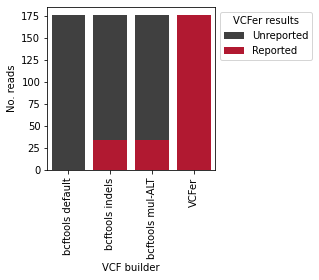

In [148]:
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(3, 3))
sns.barplot(data = examplesum,
                y='No. reads corrected',x='Tool',hue = 'Value',dodge = False, ax=axs,
           palette={
'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'})

axs.set_ylabel('No. reads') 
axs.set_xlabel('VCF builder')
plt.legend(bbox_to_anchor=(1.0, 1.0),title='VCFer results')  
plt.xticks(rotation=90)
plt.savefig('samtovcf/indelsvcfervsbcftools/Example.pdf')


In [175]:
examplemapping = pd.read_csv('samtovcf/indelsvcfervsbcftools/examplereads.mapping.txt',sep='\t')
examplemapping = examplemapping[examplemapping['readID'].isin(readID_in + ['all'])]
examplemapping = examplemapping.sort_values('readID',ascending=False)
examplemapping = examplemapping[~examplemapping['readID'].str.contains('_')]
examplemappingsub = examplemapping[examplemapping['readID'].isin(
    ['50','104','16',  '108',                                        
     '180','2','208','86'])]
examplemapping = examplemapping[~examplemapping['readID'].isin(
    ['50','104','108','130','134','140','16','164',
                                                                  
     '180','198','2','202','208','46','50','52','86','88'])]

examplemappingsub['readID'] = examplemappingsub['readID'] + '_' + '1'
examplemapping = examplemapping.append(examplemappingsub)
examplemappingsub['readID'] = [x.replace('_1','_2') for x in examplemappingsub['readID']]
examplemapping = examplemapping.append(examplemappingsub)
examplemapping.head()

,readID,VCFer,bcftools (multi-alleles),bcftools (default),bcftools (indels)
174,all,True,False,False,False
172,98,True,False,False,False
170,96,True,False,False,False
168,94,True,False,False,False
166,92,True,False,False,False


In [178]:
pd.DataFrame(examplemapping.groupby(['VARIANTS','bcftools mul-ALT','bcftools default','bcftools indel'])['VCFer'].count()
)

VCFer
VCFer bcftools (multi-alleles) bcftools (default) bcftools (indels)       
True  False                    False              False                 73
                                                  True                   2
      True                     False              False                  2
                                                  True                   8

In [179]:
examplemappingall = examplemapping.loc[:,['readID','VCFer']]
examplemappingall['Tool']='VAIRNATS'
examplemappingall['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingall['VCFer']]
examplemappingall = examplemappingall.loc[:,['readID','Tool','Value']]

examplemappingsub = examplemapping.loc[:,['readID','bcftools (multi-alleles)']]
examplemappingsub['Tool']='bcftools mul-ALT'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (multi-alleles)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (default)']]
examplemappingsub['Tool']='bcftools default'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (default)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (indels)']]
examplemappingsub['Tool']='bcftools indel'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (indels)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingall = examplemappingall.sort_values('readID',ascending=True)
examplemappingall.tail()


,readID,Tool,Value
172,98,VCFer,Reported
174,all,bcftools default,Unreported
174,all,bcftools mul-ALT,Unreported
174,all,bcftools indels,Unreported
174,all,VCFer,Reported


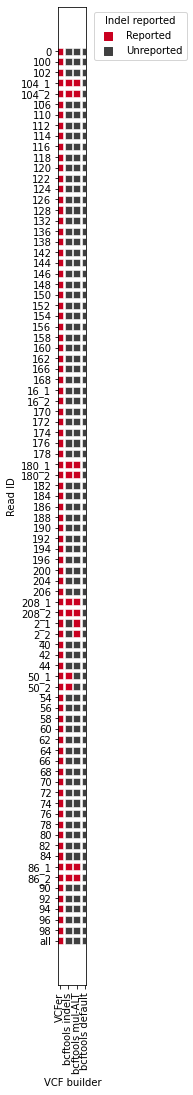

In [184]:
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(0.5, 18))
sns.scatterplot(x='Tool', y='readID', hue = 'Value',data=examplemappingall,ax = axs,
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},
                style='Value', markers={'Reported':'s','Unreported': 's', 'Incorrectly reported': 's'},
                size = 'Value',sizes={'Reported':50,'Unreported': 50, 'Incorrectly reported': 50})
axs.set_xlabel('VCF builder') 
axs.set_ylabel('Read ID')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.1, 1.0),title = 'Indel reported')
plt.savefig('samtovcf/indelsvcfervsbcftools/readID.pdf')


In [182]:
examplemappingall3 = examplemappingall[examplemappingall['readID']!='all']
pd.DataFrame(examplemappingall3.groupby(['Tool','Value'])['Value'].count())

Value
Tool             Value            
VCFer            Reported       84
bcftools default Unreported     84
bcftools indels  Reported       10
                 Unreported     74
bcftools mul-ALT Reported       10
                 Unreported     74

In [299]:
# compare to read dis to insertion
from Bio import SeqIO
allalignment = {}
allpairedread = []
for record in SeqIO.parse('samtovcf/indelsvcfervsbcftools/examplereads.aligned.fasta', 'fasta'):
    allalignment.setdefault(str(record.id),str(record.seq))
    if '_' in str(record.id):
        allpairedread.append(str(record.id).split('_')[0])


In [300]:
examplemapping = pd.read_csv('samtovcf/indelsvcfervsbcftools/examplereads.mapping.txt',sep='\t')
examplemapping = examplemapping[~examplemapping['readID'].isin(['all','allsub'])]
examplemappingsub = examplemapping[examplemapping['readID'].isin(
    allpairedread)]
examplemapping = examplemapping[~examplemapping['readID'].isin(
    allpairedread)]

examplemappingsub['readID'] = examplemappingsub['readID'] + '_' + '1'
examplemapping = examplemapping.append(examplemappingsub)
examplemappingsub['readID'] = [x.replace('_1','_2') for x in examplemappingsub['readID']]
examplemapping = examplemapping.append(examplemappingsub)
examplemappingall = examplemapping.loc[:,['readID','VCFer']]
examplemappingall['Tool']='VARIANTS'
examplemappingall['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingall['VCFer']]
examplemappingall = examplemappingall.loc[:,['readID','Tool','Value']]

examplemappingsub = examplemapping.loc[:,['readID','bcftools (multi-alleles)']]
examplemappingsub['Tool']='bcftools mul-ALT'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (multi-alleles)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (default)']]
examplemappingsub['Tool']='bcftools default'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (default)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (indels)']]
examplemappingsub['Tool']='bcftools indel'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (indels)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingall = examplemappingall.sort_values('readID',ascending=True)
examplemappingall.tail()


,readID,Tool,Value
172,98,bcftools mul-ALT,Unreported
173,99,VCFer,Reported
173,99,bcftools indels,Unreported
173,99,bcftools mul-ALT,Unreported
173,99,bcftools default,Unreported


In [301]:
pd.DataFrame(examplemappingall.groupby(['Tool','Value'])['Value'].count())

Value
Tool             Value            
VCFer            Reported      215
bcftools default Unreported    215
bcftools indels  Reported       68
                 Unreported    147
bcftools mul-ALT Reported       68
                 Unreported    147

In [302]:
def seq_dis_insertion(readseq):
    startpos = min(readseq.index('a'),
                  readseq.index('t'),
                  readseq.index('g'),
                  readseq.index('c'))
    return insertion_POS - startpos
insertion_POS = allalignment['ref'].index('-')
allalignmentinsertionplace = pd.DataFrame(
{
    'readID' : allalignment.keys(),
    'Dis_insertion' : 0
}
)
for i in allalignmentinsertionplace.index:
    readID = allalignmentinsertionplace.loc[i,'readID']
    readseq = allalignment[readID]
    allalignmentinsertionplace.loc[i,'Dis_insertion'] = seq_dis_insertion(readseq)
allalignmentinsertionplace['readID'] = [x.replace('_1','_2').replace('_0','_1') for
                                        x in allalignmentinsertionplace['readID']]
allalignmentinsertionplace.sort_values('readID')


,readID,Dis_insertion
1,0,115
2,1,28
3,100,100
4,101,100
5,102,100
...,...,...
212,96,103
213,97,100
214,98,100
215,99,100


In [303]:
examplemappingall2 = examplemappingall.merge(allalignmentinsertionplace,left_on = 'readID',right_on = 'readID',
                                           how = 'left')
examplemappingall2 = examplemappingall2[examplemappingall2['readID']!='all'][examplemappingall2['readID']!='allsub']
examplemappingall2.head(30)

,readID,Tool,Value,Dis_insertion
0,0,VCFer,Reported,115
1,0,bcftools mul-ALT,Unreported,115
2,0,bcftools default,Unreported,115
3,0,bcftools indels,Unreported,115
4,1,bcftools indels,Unreported,28
5,1,bcftools default,Unreported,28
6,1,VCFer,Reported,28
7,1,bcftools mul-ALT,Unreported,28
8,100,bcftools default,Unreported,100
9,100,bcftools indels,Unreported,100


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


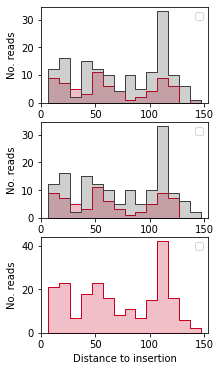

In [304]:
fig, axs = plt.subplots(nrows=3,ncols = 1,figsize=(3, 6),sharex='row')
sns.histplot(x='Dis_insertion', hue = 'Value',binwidth=10,
             data=examplemappingall2[examplemappingall2['Tool']==
                                                                                   'bcftools mul-ALT'],ax = axs[0],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[0].set_xlabel('Distance to insertion') 
axs[0].set_ylabel('No. reads') 
sns.histplot(x='Dis_insertion', hue = 'Value',binwidth=10,
             data=examplemappingall2[examplemappingall2['Tool']==
                                                                                   'bcftools indel'],ax = axs[1],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[1].set_xlabel('Distance to insertion (bp)') 
axs[1].set_ylabel('No. reads') 
sns.histplot(x='Dis_insertion', hue = 'Value',binwidth=10,
             data=examplemappingall2[examplemappingall2['Tool']==
                                                                                   'VARIANTS'],ax = axs[2],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[2].set_xlabel('Distance to insertion') 
axs[2].set_ylabel('No. reads') 
plt.sca(axs[0])
plt.legend(bbox_to_anchor=(1, 1.0))

plt.sca(axs[1])
plt.legend(bbox_to_anchor=(1, 1.0))
plt.sca(axs[2])
plt.legend(bbox_to_anchor=(1, 1.0))
plt.savefig('samtovcf/indelsvcfervsbcftools/readID3.pdf')


In [60]:
# compute distance between 2 reads
examplemapping = pd.read_csv('samtovcf/indelsvcfervsbcftools/examplereads.mapping.txt',sep='\t')
examplemapping = examplemapping[~examplemapping['readID'].isin(['all','allsub'])]
examplemapping['readID'] = examplemapping['readID'] + '_' + '1'
# examplemappingsub = examplemapping[examplemapping['readID'].isin(examplemapping['readID'])]
# examplemappingsub['readID'] = [x.replace('_1','_2') for x in examplemappingsub['readID']]
# examplemapping = examplemapping.append(examplemappingsub)
examplemappingall = examplemapping.loc[:,['readID','VCFer']]
examplemappingall['Tool']='VARIANTS'
examplemappingall['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingall['VCFer']]
examplemappingall = examplemappingall.loc[:,['readID','Tool','Value']]

examplemappingsub = examplemapping.loc[:,['readID','bcftools (multi-alleles)']]
examplemappingsub['Tool']='bcftools mul-ALT'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (multi-alleles)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (default)']]
examplemappingsub['Tool']='bcftools default'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (default)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingsub = examplemapping.loc[:,['readID','bcftools (indels)']]
examplemappingsub['Tool']='bcftools indel'
examplemappingsub['Value'] = [str(x).replace('True','Reported').replace('False','Unreported') for x in examplemappingsub['bcftools (indels)']]
examplemappingsub = examplemappingsub.loc[:,['readID','Tool','Value']]
examplemappingall = examplemappingall.append(examplemappingsub)

examplemappingall = examplemappingall.sort_values('readID',ascending=True)

def compute_dis(CHR1,POS1,read1_len,CHR2,POS2):
    POS1 = int(POS1)
    POS2 = int(POS2)
    if CHR1 == CHR2:
        return POS2-(POS1+read1_len)
    else:
        length1 = int(CHR1.split('size')[1])
        length2 = int(CHR2.split('size')[1])
        POS1 = min(abs(length1 - POS1),POS1 - 0)
        POS2 = min(abs(length2 - POS2),POS2 - 0)
        return POS1 + POS2 - read1_len
    
def compute_dis_sam(samfile):
    sam = pd.read_csv(samfile,sep='\t',header=None,comment = '@',usecols=[0,1,2,3,5, 9])
    dis_pairs = compute_dis(sam.loc[0,2],sam.loc[0,3],len(sam.loc[0,9]),sam.loc[1,2],sam.loc[1,3])
    return dis_pairs

examplemappingall['Dis_pairreads'] = 0
allsamfiles = glob.glob('samtovcf/indelsvcfervsbcftools/samfiles/*.sam')
for samfile in allsamfiles:
    readID = os.path.basename(samfile).split('.sam')[0] + '_1'
    examplemappingall.loc[examplemappingall['readID']==readID,'Dis_pairreads'] = compute_dis_sam(samfile)
examplemappingall.head()


,readID,Tool,Value,Dis_pairreads
0,0_1,VARIANTS,Reported,46
0,0_1,bcftools default,Unreported,46
0,0_1,bcftools indel,Unreported,46
0,0_1,bcftools mul-ALT,Unreported,46
2,100_1,bcftools default,Unreported,28


In [61]:
examplemappingall.head(30)

,readID,Tool,Value,Dis_pairreads
0,0_1,VARIANTS,Reported,46
0,0_1,bcftools default,Unreported,46
0,0_1,bcftools indel,Unreported,46
0,0_1,bcftools mul-ALT,Unreported,46
2,100_1,bcftools default,Unreported,28
2,100_1,bcftools indel,Unreported,28
2,100_1,bcftools mul-ALT,Unreported,28
2,100_1,VARIANTS,Reported,28
3,101_1,bcftools mul-ALT,Unreported,-60
3,101_1,bcftools default,Unreported,-60


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


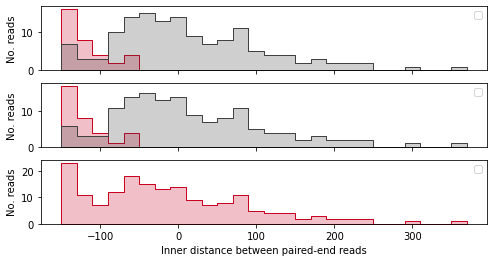

In [64]:
fig, axs = plt.subplots(nrows=3,ncols = 1,figsize=(8, 4),sharex='col')
sns.histplot(x='Dis_pairreads', hue = 'Value',binwidth=20,
             data=examplemappingall[examplemappingall['Tool']==
                                                                                   'bcftools mul-ALT'],ax = axs[0],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[0].set_xlabel('Distance between pair-end reads') 
axs[0].set_ylabel('No. reads') 
sns.histplot(x='Dis_pairreads', hue = 'Value',binwidth=20,
             data=examplemappingall[examplemappingall['Tool']==
                                                                                   'bcftools indel'],ax = axs[1],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[1].set_xlabel('Distance between pair-end reads') 
axs[1].set_ylabel('No. reads') 
sns.histplot(x='Dis_pairreads', hue = 'Value',binwidth=20,
             data=examplemappingall[examplemappingall['Tool']==
                                                                                   'VARIANTS'],ax = axs[2],
               palette={'Reported':'#ca0020','Unreported':'#404040','Incorrectly reported':'#0571b0'},element="step")
axs[2].set_xlabel('Inner distance between paired-end reads') 
axs[2].set_ylabel('No. reads') 
plt.sca(axs[0])
plt.legend(bbox_to_anchor=(1, 1.0))

plt.sca(axs[1])
plt.legend(bbox_to_anchor=(1, 1.0))
plt.sca(axs[2])
plt.legend(bbox_to_anchor=(1, 1.0))
plt.savefig('samtovcf/indelsvcfervsbcftools/readID4.pdf')


In [4]:
# covid 9452
def compute_dis(CHR1,POS1,CHR2,POS2):
    POS1 = int(POS1)
    POS2 = int(POS2)
    if CHR1 == CHR2:
        return abs(POS1 - POS2)
    else:
        length1 = int(CHR1.split('size')[1])
        length2 = int(CHR2.split('size')[1])
        POS1 = min(abs(length1 - POS1),POS1 - 0)
        POS2 = min(abs(length2 - POS2),POS2 - 0)
        return POS1 + POS2
    
def compute_dis_sam(samfile):
    sam = pd.read_csv(samfile,sep='\t',header=None,comment = '@',usecols=[0,1,2,3,5, 9])
    dis_pairs = compute_dis(sam.loc[0,2],sam.loc[0,3],sam.loc[1,2],sam.loc[1,3])
    return dis_pairs

allsamfiles = glob.glob('samtovcf/examplecovid//samfiles/*.sam')
for samfile in allsamfiles:
    readID = os.path.basename(samfile).split('.sam')[0] + '_1'
    print(samfile,compute_dis_sam(samfile))


samtovcf/examplecovid//samfiles/15.sam 139
samtovcf/examplecovid//samfiles/29.sam 248
samtovcf/examplecovid//samfiles/28.sam 243
samtovcf/examplecovid//samfiles/14.sam 139
samtovcf/examplecovid//samfiles/16.sam 71
samtovcf/examplecovid//samfiles/17.sam 250
samtovcf/examplecovid//samfiles/13.sam 139
samtovcf/examplecovid//samfiles/12.sam 139
samtovcf/examplecovid//samfiles/38.sam 166
samtovcf/examplecovid//samfiles/10.sam 140
samtovcf/examplecovid//samfiles/11.sam 254
samtovcf/examplecovid//samfiles/39.sam 198
samtovcf/examplecovid//samfiles/9.sam 287
samtovcf/examplecovid//samfiles/8.sam 145
samtovcf/examplecovid//samfiles/5.sam 25
samtovcf/examplecovid//samfiles/4.sam 25
samtovcf/examplecovid//samfiles/40.sam 423
samtovcf/examplecovid//samfiles/6.sam 145
samtovcf/examplecovid//samfiles/7.sam 145
samtovcf/examplecovid//samfiles/3.sam 497
samtovcf/examplecovid//samfiles/2.sam 53
samtovcf/examplecovid//samfiles/0.sam 119
samtovcf/examplecovid//samfiles/1.sam 119
samtovcf/examplecovid//sa

In [27]:
# exampleSNP depth
targetPOS = 36222
DP_indel = pd.read_csv('samtovcf/exampleSNP/DP_indel.txt',sep='\t',
                      comment = '#')
DP_default = pd.read_csv('samtovcf/exampleSNP/DP_default.txt',sep='\t',
                      comment = '#')
DP_bcf = pd.read_csv('samtovcf/exampleSNP/DP_bcf.txt',sep='\t',
                      comment = '#')
DP_indel.head()

,POS,DP
0,36202,100
1,36203,102
2,36204,107
3,36205,107
4,36206,107


In [28]:
DP_variants = pd.read_csv('samtovcf/exampleSNP/allsub.vcfer.vcf',sep='\t',
                      comment = '#')
DP_variants = DP_variants[DP_variants['POS']<=targetPOS + 20][DP_variants['POS']>=targetPOS - 20]
newPOS = 193
DP_indel['POS']=DP_indel['POS']-targetPOS + newPOS
DP_default['POS']=DP_default['POS']-targetPOS + newPOS
DP_bcf['POS']=DP_bcf['POS']-targetPOS + newPOS
DP_variants['POS']=DP_variants['POS']-targetPOS + newPOS
DP_variants.head()

,CHR,POS,REF,ALT,DP,DETAILS-MIDDLE,DETAILS-ENDS,SUPPORT
498,NODE_12_length_206813_cov_40.160886,36202,A,NaN,100,"63,24.5","6.5,6",NaN
499,NODE_12_length_206813_cov_40.160886,36203,T,NaN,102,"63,24.5","8,6.5",NaN
500,NODE_12_length_206813_cov_40.160886,36204,A,NaN,107,"61.5,24.5","8,13",NaN
501,NODE_12_length_206813_cov_40.160886,36205,G,C,107,"60.5,24.5;1,0","8,13;0,0",ATGCAGTACCTCAAGGAAGAATGTATTACACCTGTGTTCTCTAAAG...
502,NODE_12_length_206813_cov_40.160886,36206,A,NaN,107,"61,24.5","8,13.5",NaN


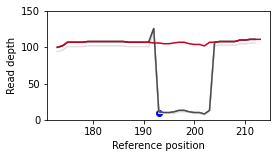

In [115]:
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(4, 2))
sns.lineplot(x='POS', y = 'DP',
             data=DP_indel,ax = axs,color = '#878787')
sns.lineplot(x='POS', y = 'DP',
             data=DP_default,ax = axs,color = '#e0e0e0')
sns.lineplot(x='POS', y = 'DP',
             data=DP_bcf,ax = axs,color = '#4d4d4d')
sns.lineplot(x='POS', y = 'DP',
             data=DP_variants,ax = axs,color = '#ca0020')
axs.set_xlabel('Reference position') 
axs.set_ylabel('Read depth') 
# plt.sca(axs)
# plt.legend(bbox_to_anchor=(1, 1.0))
axs.set_ylim([0,150])
plt.scatter( newPOS, 10, color='blue')
plt.savefig('samtovcf/exampleSNP/DP.pdf')


In [126]:
#INDEL MAF
indelmaf = pd.read_csv('samtovcf/indelsvcfervsbcftools//modelindelsumall.txt',sep='\t')
indelmaf['VCF caller'] = ''
indelmaf['VCF caller']=[x.replace('bowtie2 VARIANTS','VARIANTS'
                            ).replace('minimap2 VARIANTS','VARIANTS'
                                     ).replace('bwa VARIANTS','VARIANTS'
                                              ).replace('bowtie2 indel','bcftools indel'
                            ).replace('minimap2 indel','bcftools indel'
                                     ).replace('bwa indel','bcftools indel'
                                              ).replace('bowtie2 bcfdefault','bcftools default'
                            ).replace('minimap2 bcfdefault','bcftools default'
                                     ).replace('bwa bcfdefault','bcftools default'
                                              ).replace('bowtie2','bcftools Mul-ALT'
                            ).replace('minimap2','bcftools Mul-ALT'
                                     ).replace('bwa','bcftools Mul-ALT'
                                              ) for x in indelmaf['Tool']]
indelmaf['Tool'] = [x.split(' ')[0] for x in indelmaf['Tool']]
indelmaf=indelmaf[indelmaf['Sample']!='am_AkMu_g0002.fasta.corrected.0.SNP.fasta']
indelmaf=indelmaf[indelmaf['Sample']!='am_BaOv_g0001.fasta.corrected.0.SNP.fasta']

indelmaf.head()

,MAF,Sample,Tool,FN,TP,FP_samePOS,FP_diffPOS,VCF caller
5,0.05,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,53,159,30,55,bcftools Mul-ALT
6,0.05,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,15,196,28,26,VARIANTS
7,0.05,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,87,114,16,10,bcftools default
8,0.05,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,54,154,19,49,bcftools indel
9,0.05,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,minimap2,54,154,19,49,bcftools indel


In [128]:
indelmaf.tail()

,MAF,Sample,Tool,FN,TP,FP_samePOS,FP_diffPOS,VCF caller
195,1.0,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,200,0,0,0,bcftools Mul-ALT
196,1.0,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,111,89,10,4,VARIANTS
197,1.0,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,200,0,0,0,bcftools default
198,1.0,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,bowtie2,179,21,2,8,bcftools indel
199,1.0,am_AkMu_g0002.fasta.corrected.4e-02.SNP.fasta,minimap2,179,21,2,8,bcftools indel


In [129]:
print(87/15,54/15,200/111,179/111)

5.8 3.6 1.8018018018018018 1.6126126126126126


In [130]:
print(49/26,8/4)

1.8846153846153846 2.0


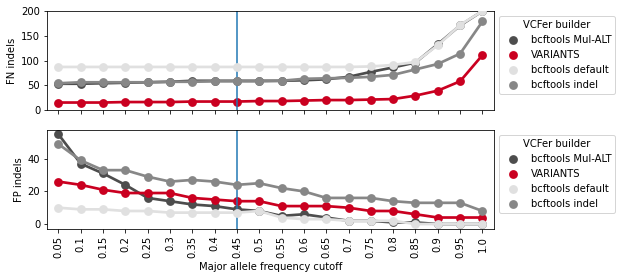

In [127]:
pallete_set = {
        'VARIANTS':'#ca0020','bcftools Mul-ALT':'#4d4d4d','bcftools default':'#e0e0e0','bcftools indel':'#878787'}

fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(8, 4),sharex='col')
sns.pointplot(data = indelmaf,
                y='FN',x='MAF',hue = 'VCF caller', ax=axs[0],
           palette=pallete_set)
axs[0].axvline(x=8)

axs[0].set_ylabel('FN indels') 
axs[0].set_xlabel('')
axs[0].set_ylim([0,200])
plt.sca(axs[0])
plt.legend(bbox_to_anchor=(1.0, 1.0),title='VCFer builder')  
plt.xticks(rotation=90)
sns.pointplot(data = indelmaf,
                y='FP_diffPOS',x='MAF',hue = 'VCF caller', ax=axs[1],
           palette=pallete_set)
axs[1].axvline(x=8)

axs[1].set_ylabel('FP indels') 
axs[1].set_xlabel('Major allele frequency cutoff')
plt.sca(axs[1])
plt.legend(bbox_to_anchor=(1.0, 1.0),title='VCFer builder')  
plt.xticks(rotation=90)

plt.savefig('samtovcf/indelsvcfervsbcftools/MAF.pdf')


In [36]:
#INDEL MAF COVID
indelmaf = pd.read_csv('samtovcf/examplecovid//modelindelsumall.txt',sep='\t')
indelmaf['VCF caller'] = ''
indelmaf['VCF caller']=[x.replace('bowtie2 VARIANTS','VARIANTS'
                            ).replace('minimap2 VARIANTS','VARIANTS'
                                     ).replace('bwa VARIANTS','VARIANTS'
                                              ).replace('bowtie2 indel','bcftools indel'
                            ).replace('minimap2 indel','bcftools indel'
                                     ).replace('bwa indel','bcftools indel'
                                              ).replace('bowtie2 bcfdefault','bcftools default'
                            ).replace('minimap2 bcfdefault','bcftools default'
                                     ).replace('bwa bcfdefault','bcftools default'
                                              ).replace('bowtie2','bcftools Mul-ALT'
                            ).replace('minimap2','bcftools Mul-ALT'
                                     ).replace('bwa','bcftools Mul-ALT'
                                              ) for x in indelmaf['Tool']]
indelmaf['Tool'] = [x.split(' ')[0] for x in indelmaf['Tool']]
indelmaf=indelmaf[indelmaf['Sample']!='am_AkMu_g0002.fasta.corrected.0.SNP.fasta']
indelmaf.head()

,MAF,Sample,Tool,FN,TP,FP_samePOS,FP_diffPOS,VCF caller
0,0.05,SRR10971381.fasta.200.SNP1.fasta,minimap2,0,20,0,1,bcftools Mul-ALT
1,0.05,SRR10971381.fasta.200.SNP1.fasta,minimap2,2,18,2,1,VARIANTS
2,0.05,SRR10971381.fasta.200.SNP1.fasta,minimap2,0,20,0,0,bcftools default
3,0.05,SRR10971381.fasta.200.SNP1.fasta,minimap2,0,20,0,1,bcftools indel
4,0.10,SRR10971381.fasta.200.SNP1.fasta,minimap2,0,20,0,0,bcftools Mul-ALT


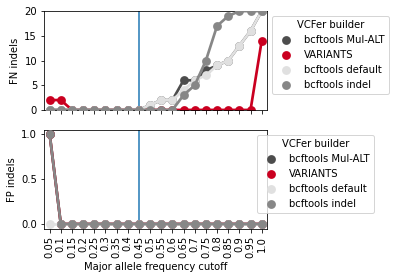

In [37]:
pallete_set = {
        'VARIANTS':'#ca0020','bcftools Mul-ALT':'#4d4d4d','bcftools default':'#e0e0e0','bcftools indel':'#878787'}

fig, axs = plt.subplots(nrows=2,ncols = 1,figsize=(4, 4),sharex='col')
sns.pointplot(data = indelmaf,
                y='FN',x='MAF',hue = 'VCF caller', ax=axs[0],
           palette=pallete_set)
axs[0].axvline(x=8)

axs[0].set_ylabel('FN indels') 
axs[0].set_xlabel('')
axs[0].set_ylim([0,20])
plt.sca(axs[0])
plt.legend(bbox_to_anchor=(1.0, 1.0),title='VCFer builder')  
plt.xticks(rotation=90)
sns.pointplot(data = indelmaf,
                y='FP_diffPOS',x='MAF',hue = 'VCF caller', ax=axs[1],
           palette=pallete_set)
axs[1].axvline(x=8)

axs[1].set_ylabel('FP indels') 
axs[1].set_xlabel('Major allele frequency cutoff')
plt.sca(axs[1])
plt.legend(bbox_to_anchor=(1.5, 1.0),title='VCFer builder')  
plt.xticks(rotation=90)

plt.savefig('samtovcf/examplecovid//MAF.pdf')


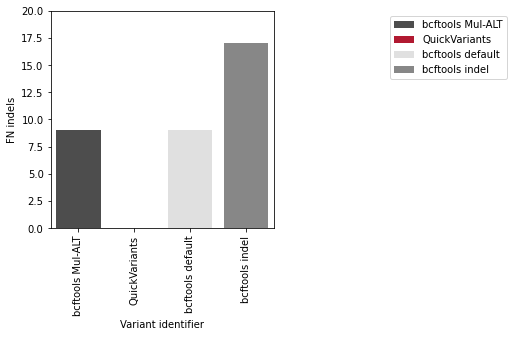

In [41]:
pallete_set = {
        'QuickVariants':'#ca0020','bcftools Mul-ALT':'#4d4d4d','bcftools default':'#e0e0e0','bcftools indel':'#878787'}
indelmaf['VCF caller'] = [x.replace('VARIANTS','QuickVariants') for x in indelmaf['VCF caller']]
fig, axs = plt.subplots(nrows=1,ncols = 1,figsize=(4, 4),sharex='col')
sns.barplot(data = indelmaf[indelmaf['MAF']==0.8],
                y='FN',x='VCF caller',hue = 'VCF caller', ax=axs,dodge=False,
           palette=pallete_set)

axs.set_ylabel('FN indels') 
axs.set_xlabel('Variant identifier')
axs.set_ylim([0,20])
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.5, 1.0))  
plt.savefig('samtovcf/examplecovid//COVID.pdf')
